The goal of this work is to synthesise a ML model to predict room occupancy based on reading from Internet of Things (IoT) sensors.

The dataset was collected by [Candanedo et al](https://github.com/LuisM78/Occupancy-detection-data) and uploaded to [Kaggle](https://www.kaggle.com/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/data).

# 0. Import libraries and connect to Kagglehub

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kukuroo3/room-occupancy-detection-data-iot-sensor")

print("Path to dataset files:", path)

100%|██████████| 263k/263k [00:00<00:00, 60.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/versions/2


Uploading dataset and checking its integrity

In [5]:
df = pd.read_csv(path+'/Occupancy.csv')

In [6]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [7]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [9]:
df.isna().sum()

,0
date,0
Temperature,0
Humidity,0
Light,0
CO2,0
HumidityRatio,0
Occupancy,0


It seems like there are no missing values in our dataset, we can proceed to the next step.

# 1. EDA

Let's run a surface-level EDA and visualize distributions of parameters.

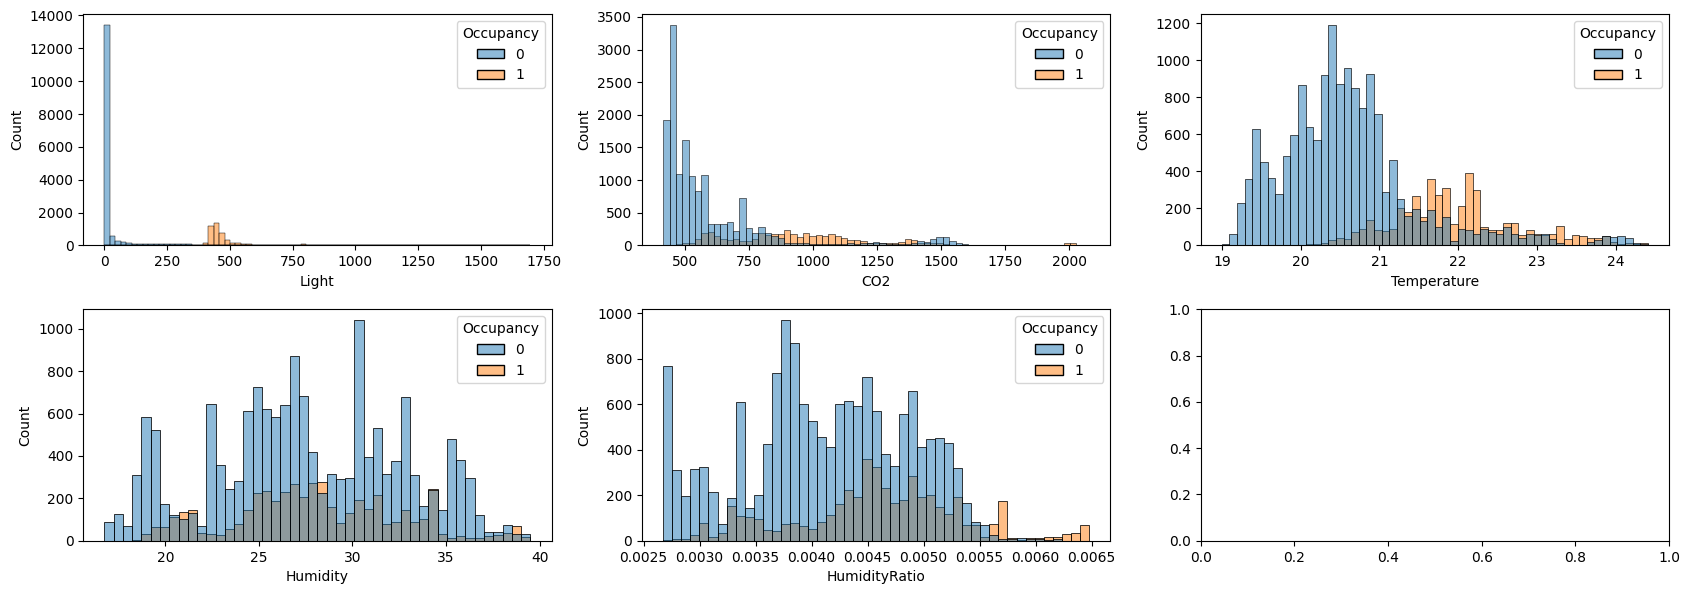

In [10]:
fig, axs = plt.subplots(2,3, figsize=(17, 6))
sns.histplot(ax=axs[0, 0],data=df, x='Light', hue='Occupancy')
sns.histplot(ax=axs[0, 1], data=df, x='CO2', hue='Occupancy')
sns.histplot(ax=axs[0, 2], data=df, x='Temperature', hue='Occupancy')
sns.histplot(ax=axs[1, 0], data=df, x='Humidity', hue='Occupancy')
sns.histplot(ax=axs[1, 1], data=df, x='HumidityRatio', hue='Occupancy')
fig.tight_layout()

Judging by these distributions, it seems like light is the main predictor of occupancy. It makes sense: we don't know much about the room, but people who work there probably turn on the light when their workday begins and turn it off at the end, making it a perfect predictor. Let's gather some more data by applying phi_k coefficient and building a correlation matrix.

In [11]:
!pip install phik
from phik.report import plot_correlation_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 26.4 MB/s eta 0:00:00


interval columns not set, guessing: ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']


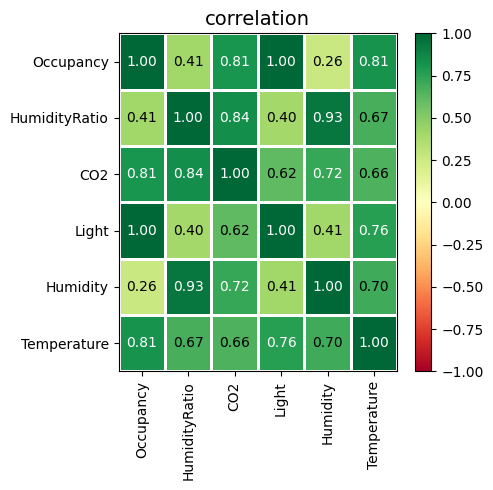

In [12]:
phik_overview = df.drop(columns=['date']).phik_matrix() #drop the timestamp, we are only interested in sensor readings
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, figsize=(5, 5))

It looks like light is indeed a perfect predictor for occupancy. Lets proceed with the full dataset and see how accurate the model will be if we keep all parameters.

# 2. Building a model

Before we begin training our model, we need to check the balance of classes in our target variable.

<Axes: xlabel='Occupancy', ylabel='count'>

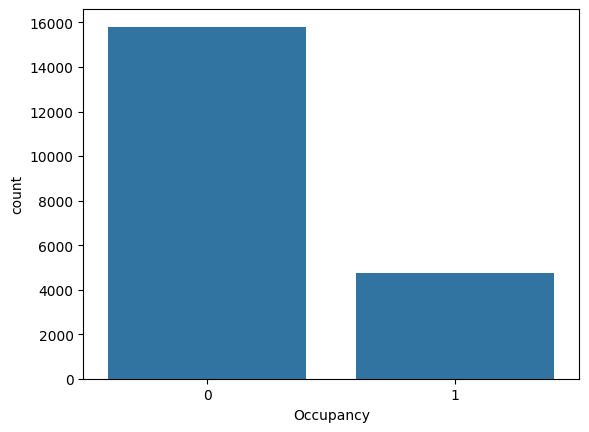

In [13]:
sns.countplot(df, x='Occupancy')

In [15]:
df['Occupancy'].value_counts(normalize=True)

,proportion
Occupancy,
0,0.768969
1,0.231031


Samples marked as "occupied" are only 23% of our dataset. It makes sense, since working hours are approximately 24% of the entire workweek (40 hours out of 168 total). We will use oversampling methors to compensate for this imbalance, but first, we're going to perfore a train-test split.

In [27]:
from sklearn.model_selection import train_test_split

X = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']] #predictors
y = df['Occupancy'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y) #target classes are imbalanced, so we stratify by target

In [28]:
from imblearn.over_sampling import RandomOverSampler #oversamling using Random Oversampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Let's check if the target is balanced now

In [29]:
y_resampled.value_counts(normalize=True)

,proportion
Occupancy,
0,0.5
1,0.5


Now that we've finished prepairing the dataset, we will build a baseline model using Decision Tree classifier and assess it using cross-validation.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


full_classifier = DecisionTreeClassifier()
scores = cross_val_score(full_classifier, X_resampled[['Light']], y_resampled, cv=10)
print(np.average(scores))

0.9919750186375593


As expected, our predictions are near perfect: light is a great predictor for occupancy.

But in some cases, we might need to predict room occupancy without light: for example, if we are building an alarm system. We will probably make our work a little harder, but we will drop 'Light' from our predictors and try to build another decision tree classifier. We will also remove 'Humidity' since it correlates strongly with 'Humidity ratio'.

In [31]:
X_resampled.drop(columns=['Light','Humidity'], inplace=True)

compact_classifier = DecisionTreeClassifier()
roc_auc_scores = cross_val_score(compact_classifier, X_resampled, y_resampled, cv=10)
print(np.average(roc_auc_scores))

0.9918564884494019


# 3. Validation

It seems like we can achieve good scores even a limited number of predictors! We can now train the model...

In [32]:
compact_classifier.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

...and make predictions:

In [33]:
y_preds = compact_classifier.predict(X_test[['Temperature', 'CO2', 'HumidityRatio']])

We have to keep in mind that classes in test dataset are imbalanced (only the training dataset was oversampled). In the case of imbalanced dataset, F1-score and confusion matrix will be more feasible.

In [34]:
from sklearn.metrics import f1_score
f1_score(y_test, y_preds)

0.9443561208267091

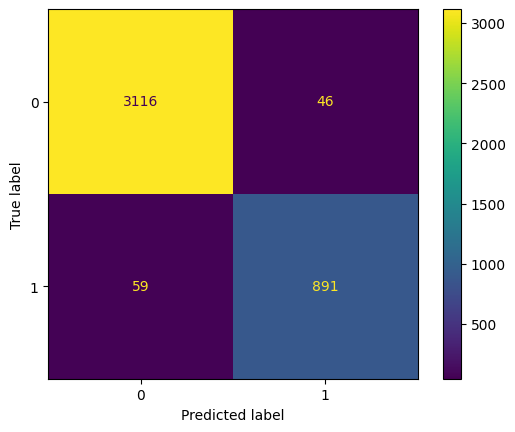

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_preds, labels=compact_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=compact_classifier.classes_)
disp.plot()

# 4. Conclusion

The F1-score of a simple decision tree reached 0.944 even without using 'Light' as a predictor.